In [1]:
import json
import os
# import xmltodict
from sys import argv
from os.path import exists
# import simplejson as json
import numpy as np
import matplotlib.pyplot as plt
import lxml.etree as ET
from geojson import Point, Feature, FeatureCollection, Polygon, dump
import geopandas as gpd
from openslide import open_slide

In [2]:
# Get path to raw data 
main_directory = os.path.dirname(os.getcwd())

#  Read in svs file
os.chdir(main_directory + '/data/raw/svs_files')
svs_data_directory = os.getcwd()
svs_files = os.listdir(svs_data_directory)

svs_file = svs_files[0]
slide = open_slide(svs_file)
slide_props = slide.properties

image_id = slide_props["aperio.Filename"]

In [7]:
# Read in xml file
os.chdir(main_directory + '/data/raw/xml_labels')
xml_data_directory = os.getcwd()

xml_file = image_id + '.xml'

In [8]:
# Check working with correct svs corresponding to xml file
print(f'svs file name is {slide_props["aperio.Filename"]}')
print(f'xml file name is {xml_file}')
print(xml_file.rstrip('.xml') == slide_props['aperio.Filename'])

svs file name is TCGA-A2-A0SY-01Z-00-DX1
xml file name is TCGA-A2-A0SY-01Z-00-DX1.xml
True


In [10]:
points = []
features = []

# Get annotations from XML file
tree = ET.parse(xml_file)
root = tree.getroot()
for Annotation in root.findall("./Annotation"): # for all annotations
    # iterate on all regions
    for Region in Annotation.findall("./*/Region"):
        # extract region attributes
        regionID = Region.attrib['Id']; regionArea = Region.attrib['Area']
        # print(regionID)
        # if regionID == '6':
            # iterate all points in region
        for Vertex in Region.findall("./*/Vertex"):
            # get points
            x_point = float(np.int32(np.float64(Vertex.attrib['X'])))
            y_point = float(np.int32(np.float64(Vertex.attrib['Y'])))
            points.append([x_point, y_point])
        # features.append(Feature(geometry=Polygon([points]), properties={"name": xml_file, "region_id": regionID, "object_type": "annotation"}))

# feature_collection = FeatureCollection(features)

# Save as geojson file
# with open('shapes.geojson', 'w') as f:
#    dump(feature_collection, f)

In [21]:
# Get downsample factors
factors = slide.level_downsamples
print(f'Downsample factors: {factors}')

# Choose level to work with
LEVEL = 2
height = slide_props[f'openslide.level[{LEVEL}].height']
width = slide_props[f'openslide.level[{LEVEL}].width']
FACTOR = factors[LEVEL]
print(f"Downsampled image height: {height} and width: {width}")
print(f"Working with image downsampled by {FACTOR}")

Downsample factors: (1.0, 4.00004470006258, 16.001443204809114, 64.00958799196559)
Downsampled image height: 5848 and width: 8389
Working with image downsampled by 16.001443204809114


In [97]:
# Downsample all annotation points
# (x, y)
downsample_points = []
for point in points:
    downsample_points.append([int(point[0]/FACTOR), int(point[1]/FACTOR)])

# Initialise downsampled binary image
binary_image = np.ones([int(height), int(width)])

for point in downsample_points:
    binary_image[point[1], point[0]] = 0

In [98]:
x_points = [downsample_points[i][0] for i in range(len(downsample_points))]
y_points = [downsample_points[i][1] for i in range(len(downsample_points))]
print(np.max(x_points))
print(np.max(y_points))

7328
5046


In [79]:
# duplicate coordinates?
print(len(list(set(map(tuple,downsample_points)))))

4212


In [55]:
print(len(downsample_points))
print(binary_image)
print(np.count_nonzero(binary_image == 0))

4287
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
4212
49054660


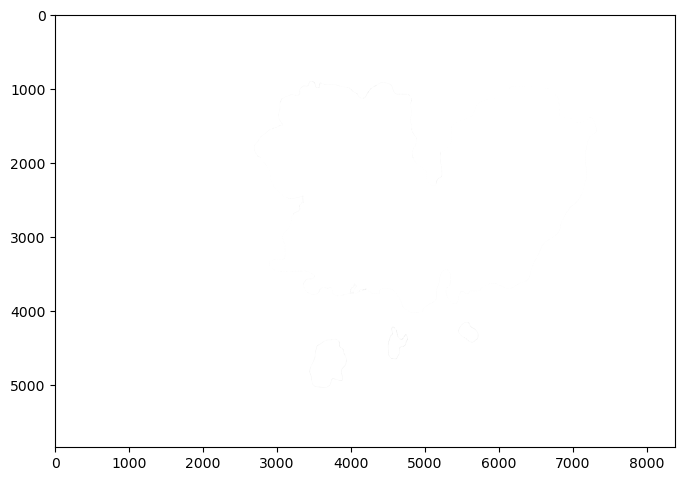

In [99]:
# Visualise binary image
plt.figure(figsize=(8,8))
plt.imshow(binary_image, cmap="gray", vmin=0, vmax=1)    

In [91]:
print(downsample_points[0])

[4619, 4267]


0.0
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


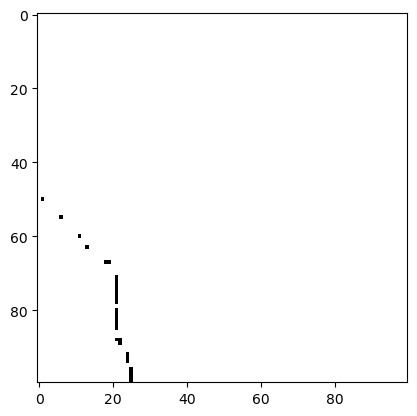

In [100]:
# Visualise binary image
print(binary_image[4267, 4619]) # x=4619, y=4267
# plot image as (y, x)
plt.imshow(binary_image[4100:4400, 4500:4700], cmap="gray", vmin=0, vmax=1) 

In [ ]:
def extract_image_patches(image, patch_size):
    # Use nn.Fold to extract image patches

In [ ]:
def extract_label_patches(xml, patch_size):
    # Initialise patch
    patch = np.zeros([patch_size, patch_size])
    # Run through points in patch and check if it is labelled
    # Keep track of patch number to work out coordinates

In [ ]:
# Create binary mask of original dimensions
